In [1]:
# Imports 
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.optim as optim
import random

In [2]:
# Define the COCO dataset class
class COCODataset(Dataset):
    def __init__(self, annotation_file, image_dir, transforms=None):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.transforms = transforms
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        image_info = coco.loadImgs(img_id)[0]
        path = image_info['file_name']

        img = cv2.imread(os.path.join(self.image_dir, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        num_objs = len(anns)
        boxes = []
        labels = []
        for i in range(num_objs):
            xmin = anns[i]['bbox'][0]
            ymin = anns[i]['bbox'][1]
            xmax = xmin + anns[i]['bbox'][2]
            ymax = ymin + anns[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(anns[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([img_id])
        
        if boxes.size(0) > 0:  # Check if there are any boxes
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.tensor([])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

In [3]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor()])

# Initialize dataset and dataloader
annotation_file = 'university_annotations/train/_annotations.coco.json'
image_dir = 'university_annotations/train/train_images'
dataset = COCODataset(annotation_file, image_dir, transforms=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


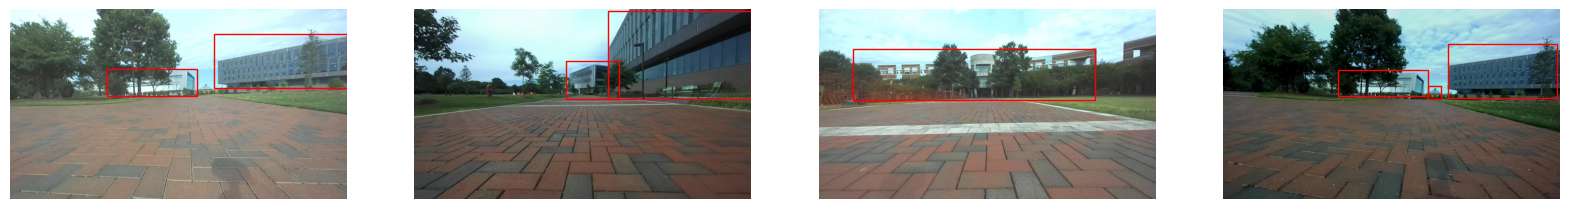

In [4]:
# Function to visualize a batch of images
def visualize_batch(images, targets):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, target) in enumerate(zip(images, targets)):
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy array
        img = (img * 255).astype(np.uint8)  # Convert to uint8
        axes[i].imshow(img)
        boxes = target['boxes'].numpy()
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red')
            axes[i].add_patch(rect)
        axes[i].axis('off')
    plt.show()

# Get a batch of data
images, targets = next(iter(dataloader))

# Visualize the batch
visualize_batch(images, targets)

In [5]:
# Load a pre-trained model for classification and return only the features
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
num_classes = len(dataset.coco.getCatIds()) + 1  # COCO class IDs + background class
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
num_epochs = 2
learning_rate = 0.005
model_save_path = "model.pt"
# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    model.train()
    print(f"Starting epoch {epoch + 1}/{num_epochs}")
    i = 0
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Iteration: {i}, Loss: {losses.item():.4f}")
        i += 1

    # Update the learning rate
    lr_scheduler.step()
    print(f"Finished epoch {epoch + 1}/{num_epochs}, Loss: {losses.item():.4f}")
    # Save the model at the end of each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
    print(f"Finished epoch {epoch + 1}/{num_epochs}, Loss: {losses.item():.4f}")

# Save the final model
torch.save(model.state_dict(), model_save_path)
print("Training complete. Model saved.")
print("Training complete.")


Starting epoch 1/2
Epoch: 1/2, Iteration: 0, Loss: 2.2473
Epoch: 1/2, Iteration: 10, Loss: 0.5457
Epoch: 1/2, Iteration: 20, Loss: 0.6939
Epoch: 1/2, Iteration: 30, Loss: 0.4404
Epoch: 1/2, Iteration: 40, Loss: 0.5243
Epoch: 1/2, Iteration: 50, Loss: 0.5306
Epoch: 1/2, Iteration: 60, Loss: 0.5404
Epoch: 1/2, Iteration: 70, Loss: 0.4659
Epoch: 1/2, Iteration: 80, Loss: 0.4164
Epoch: 1/2, Iteration: 90, Loss: 0.3239
Epoch: 1/2, Iteration: 100, Loss: 0.4021
Epoch: 1/2, Iteration: 110, Loss: 0.3873
Epoch: 1/2, Iteration: 120, Loss: 0.3876
Epoch: 1/2, Iteration: 130, Loss: 0.4231
Epoch: 1/2, Iteration: 140, Loss: 0.3133
Epoch: 1/2, Iteration: 150, Loss: 0.2631
Epoch: 1/2, Iteration: 160, Loss: 0.3140
Epoch: 1/2, Iteration: 170, Loss: 0.2403
Epoch: 1/2, Iteration: 180, Loss: 0.3673
Epoch: 1/2, Iteration: 190, Loss: 0.3831
Epoch: 1/2, Iteration: 200, Loss: 0.3651
Epoch: 1/2, Iteration: 210, Loss: 0.1769
Epoch: 1/2, Iteration: 220, Loss: 0.3549
Epoch: 1/2, Iteration: 230, Loss: 0.4444
Epoch: 1

In [6]:
# Load the model 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
num_classes = len(dataset.coco.getCatIds()) + 1  # COCO class IDs + background class
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model_save_path = "model_epoch_1.pth"
model.load_state_dict(torch.load(model_save_path))
model.eval()

/tmp/ipykernel_4497/2762269413.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

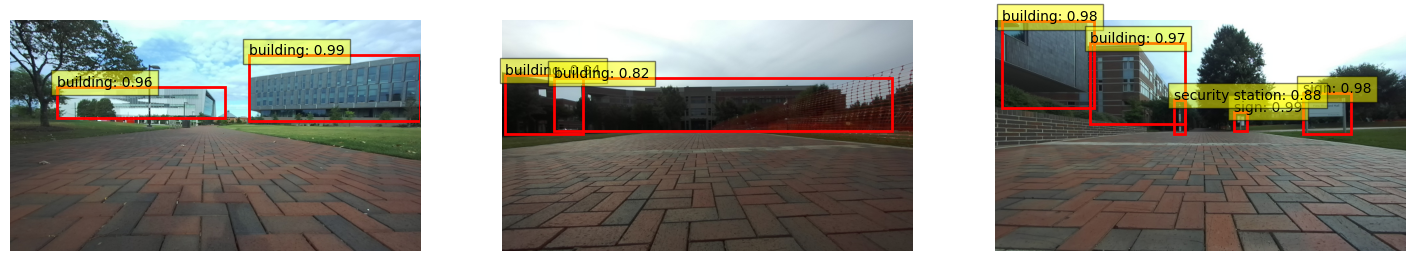

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),  
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image.unsqueeze(0) 

# Load and preprocess the test images
test_image_path1 = 'test_image1.jpg'
test_image_path2 = 'test_image2.jpg'
test_image_path3 = 'test_image3.jpg'
test_image1 = load_image(test_image_path1).to(device)
test_image2 = load_image(test_image_path2).to(device)
test_image3 = load_image(test_image_path3).to(device)

# Ensure the model is on the correct device
model = model.to(device)

# Disable gradient calculation for inference
with torch.no_grad():
    prediction1 = model(test_image1)
    prediction2 = model(test_image2)
    prediction3 = model(test_image3)

# Define categories as per the COCO dataset
categories = [
    {"id": 0, "name": "sign"},
    {"id": 1, "name": "building"},
    {"id": 2, "name": "security station"},
    {"id": 3, "name": "sign"},
    {"id": 4, "name": "structure"}
]

# Create a dictionary to map label IDs to category names
label_to_category = {cat['id']: cat['name'] for cat in categories}

def visualize_predictions(images, predictions, threshold=0.5):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for ax, image, prediction in zip(axs, images, predictions):
        # Convert the tensor image to a NumPy array and transpose the dimensions
        image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
        ax.imshow(image_np)

        boxes = prediction[0]['boxes'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()

        # Create a list of (score, label, box) tuples and sort by score descending
        predictions = sorted(zip(scores, labels, boxes), key=lambda x: x[0], reverse=True)

        # Keep track of the count of predictions per label type
        label_counts = {}

        for score, label, box in predictions:
            if score >= threshold:
                if label not in label_counts:
                    label_counts[label] = 0
                if label_counts[label] < 2:
                    xmin, ymin, xmax, ymax = box
                    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(xmin, ymin, f'{label_to_category.get(label, "Unknown")}: {score:.2f}', 
                            bbox=dict(facecolor='yellow', alpha=0.5))
                    label_counts[label] += 1

        ax.axis('off')

    plt.show()

# Visualize predictions for all three images
visualize_predictions([test_image1, test_image2, test_image3], [prediction1, prediction2, prediction3])


In [11]:
# Script that creates a cocodataset based on the prediction but only 2 BBoxes of each class based on confidence level
# Function to annotate images in COCO format
def annotate_images_in_folder(folder_path, output_json_path, threshold=0.5):
    image_id = 1
    annotation_id = 1
    coco_annotations = {
        "images": [],
        "annotations": [],
        "categories": categories
    }

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if not os.path.isfile(file_path):
            continue  # Skip directories and non-files
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image = load_image(file_path).to(device)

            with torch.no_grad():
                prediction = model(image)

            image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
            height, width, _ = image_np.shape

            coco_annotations["images"].append({
                "id": image_id,
                "file_name": filename,
                "width": int(width),
                "height": int(height)
            })

            boxes = prediction[0]['boxes'].cpu().numpy()
            scores = prediction[0]['scores'].cpu().numpy()
            labels = prediction[0]['labels'].cpu().numpy()

            # Create a list of (score, label, box) tuples and sort by score descending
            predictions = sorted(zip(scores, labels, boxes), key=lambda x: x[0], reverse=True)

            # Keep track of the count of predictions per label type
            label_counts = {}

            for score, label, box in predictions:
                if score >= threshold:
                    if label not in label_counts:
                        label_counts[label] = 0
                    if label_counts[label] < 2:
                        xmin, ymin, xmax, ymax = box
                        width = xmax - xmin
                        height = ymax - ymin
                        coco_annotations["annotations"].append({
                            "id": annotation_id,
                            "image_id": image_id,
                            "category_id": int(label),
                            "bbox": [float(xmin), float(ymin), float(width), float(height)],
                            "score": float(score)
                        })
                        label_counts[label] += 1
                        annotation_id += 1

            image_id += 1

    # Save the annotations to a JSON file
    with open(output_json_path, 'w') as f:
        json.dump(coco_annotations, f, indent=4)

# Example usage:
folder_path = 'Test_3/captured_images_test3'
output_json_path = '2BBox_Each_Class_Annotation.json'
annotate_images_in_folder(folder_path, output_json_path)
print("Finished Annotations")

Finished Annotations


In [12]:
# Script that adds the lat and lon to the cocodataset
import csv
import json
import os
from PIL import Image, ImageDraw, ImageFont

# Load the CSV file
csv_file_path = 'Test_3/data_logger_test3.csv'  
image_data = {}

with open(csv_file_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        img_name = row['img_name'].replace(':', '_')
        darker_img_name = row['darker_img_name'].replace(':', '_')
        darkest_img_name = row['darkest_img_name'].replace(':', '_')
        
        image_data[img_name] = {'latitude': row['latitude'], 'longitude': row['longitude']}
        image_data[darker_img_name] = {'latitude': row['latitude'], 'longitude': row['longitude']}
        image_data[darkest_img_name] = {'latitude': row['latitude'], 'longitude': row['longitude']}

# Print the image_data dictionary in a formatted way
formatted_image_data = json.dumps(image_data, indent=4)
# print(formatted_image_data)

# Load the COCO annotations (replace 'annotations.json' with your file)
with open('annotations/2BBox_Each_Class_Annotation.json') as f:
    coco_data = json.load(f)

# Find and print the names of images that are in image_data
found_images = [image_info['file_name'].replace(':', '_') for image_info in coco_data['images'] if image_info['file_name'].replace(':', '_') in image_data]

# Add latitude and longitude to each image's annotation in the COCO dataset
for image_info in coco_data['images']:
    img_name = image_info['file_name'].replace(':', '_')
    if img_name in image_data:
        lat_lon = image_data[img_name]
        image_info['latitude'] = lat_lon['latitude']
        image_info['longitude'] = lat_lon['longitude']

# Save the modified annotations to a new JSON file
modified_annotation_path = 'annotations/Lat_Lon_2BBox_Each_Class_Annotation.json'
with open(modified_annotation_path, 'w') as f:
    json.dump(coco_data, f, indent=4)

print(f"Modified COCO annotations saved to {modified_annotation_path}")

Modified COCO annotations saved to annotations/Lat_Lon_2BBox_Each_Class_Annotation.json


In [14]:
# Script that determines the number of images that don't have lat and lon
with open('annotations/Lat_Lon_2BBox_Each_Class_Annotation.json') as f:
    coco_data = json.load(f)
# Finds the images with no lat lon values 
unlabeled_lat_lon_images = []
for image_info in coco_data['images']:
    if "latitude" not in image_info or "longitude" not in image_info:
        unlabeled_lat_lon_images.append(image_info)
print(len(unlabeled_lat_lon_images), len(coco_data["images"]))

351 1467


In [15]:
# Script that removes the images that don't have lat and lon
# Load the JSON data from the file
with open('annotations/Lat_Lon_2BBox_Each_Class_Annotation.json') as f:
    coco_data = json.load(f)

# Identify images without latitude and longitude values
unlabeled_lat_lon_image_ids = []
for image_info in coco_data['images']:
    if "latitude" not in image_info or "longitude" not in image_info:
        unlabeled_lat_lon_image_ids.append(image_info['id'])

print(f"IDs of images without lat/lon: {unlabeled_lat_lon_image_ids}")

# Remove images without latitude and longitude values from the images list
remaining_images = []
for image_info in coco_data['images']:
    if image_info['id'] not in unlabeled_lat_lon_image_ids:
        remaining_images.append(image_info)

print(f"Remaining images count: {len(remaining_images)}")

# Remove corresponding annotations
remaining_annotations = []
for annotation in coco_data['annotations']:
    if annotation['image_id'] not in unlabeled_lat_lon_image_ids:
        remaining_annotations.append(annotation)

print(f"Remaining annotations count: {len(remaining_annotations)}")

# Update the COCO data
coco_data['images'] = remaining_images
coco_data['annotations'] = remaining_annotations

# Print the count of remaining images and annotations
print(f"Updated images count: {len(coco_data['images'])}")
print(f"Updated annotations count: {len(coco_data['annotations'])}")

# Save the updated data back to the JSON file
with open('annotations/final_Test3_annotation.json', 'w') as f:
    json.dump(coco_data, f, indent=4)


IDs of images without lat/lon: [1, 2, 3, 4, 36, 37, 40, 41, 44, 47, 49, 56, 58, 67, 70, 74, 75, 76, 79, 80, 84, 93, 97, 99, 104, 105, 110, 111, 116, 118, 123, 140, 146, 148, 149, 150, 154, 157, 158, 159, 163, 165, 166, 167, 169, 176, 177, 182, 187, 193, 195, 201, 206, 211, 225, 235, 239, 242, 247, 254, 255, 262, 265, 266, 268, 273, 282, 285, 288, 289, 292, 300, 304, 306, 309, 315, 320, 323, 328, 330, 332, 333, 347, 350, 357, 362, 363, 368, 372, 373, 375, 384, 388, 396, 399, 402, 403, 410, 413, 414, 418, 423, 434, 437, 438, 440, 442, 443, 445, 463, 469, 472, 473, 488, 489, 490, 491, 492, 494, 499, 503, 506, 511, 513, 520, 522, 527, 528, 538, 560, 567, 569, 572, 575, 576, 577, 578, 582, 585, 586, 587, 596, 604, 607, 617, 620, 624, 626, 632, 633, 636, 637, 642, 646, 648, 655, 671, 679, 682, 686, 692, 697, 704, 707, 715, 718, 724, 728, 729, 731, 744, 745, 749, 750, 752, 757, 759, 768, 769, 773, 775, 781, 791, 801, 802, 805, 807, 812, 813, 816, 820, 824, 826, 829, 835, 838, 840, 847, 853, 8